In [1]:
import numpy as np
import descent
import matplotlib.pyplot as plt
try:
    from ipywidgets import interact
except ImportError:
    from IPython.html.widgets import interact

plt.style.use(['ocean', 'seaborn-notebook'])
from functools import partial
%matplotlib inline

In [2]:
import sklearn
from sklearn.datasets import make_regression

# Sparse linear regression

We first generate a toy problem instance:

In [3]:
A, y, x = make_regression(n_samples=20, n_features=50, n_informative=5, coef=True)

We wish to solve the following:
$$ \text{minimize} \quad \| y-Ax \|_2^2 + \lambda \|x\|_1 $$ 

<Container object of 3 artists>

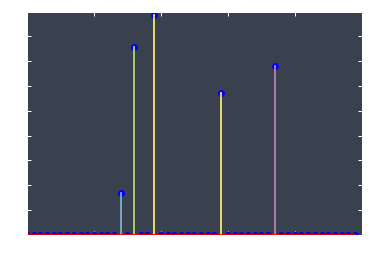

In [4]:
# here is the ground truth sparse vector
plt.stem(x, '-')

## Least squares solution

What happens if we solve the system without the sparsity penalty?

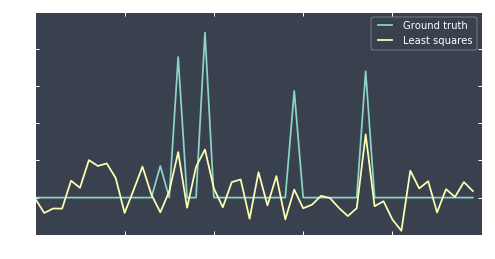

In [5]:
# compute the least squares solution
x_lsq = np.linalg.lstsq(A, y)[0]

# plot the results
plt.figure(figsize=(8,4))
plt.plot(x, '-')
plt.plot(x_lsq)
plt.legend(['Ground truth', 'Least squares'])

## Subgradient descent

One way to solve this problem is to go ahead and do gradient descent, using subgradients for the non-smooth term

In [6]:
# squared error objective
def f_df(x):
    err = A.dot(x) - y
    objective = 0.5 * np.linalg.norm(err) ** 2
    gradient = A.T.dot(err)
    return objective, gradient

# squared error + sparsity penalty
def f_df_sparse(x, penalty=1.0):
    # squared error
    obj, grad = f_df(x)
    
    # tack on the sparsity penalty
    obj_sparse = obj + penalty * np.linalg.norm(x, 1)
    grad_sparse = grad + penalty * np.sign(x)
    
    return obj_sparse, grad_sparse

In [7]:
opt_subg = descent.GradientDescent(x_lsq, f_df_sparse, 'sgd', {'lr': 0.01})
opt_subg.run(maxiter=1e4)

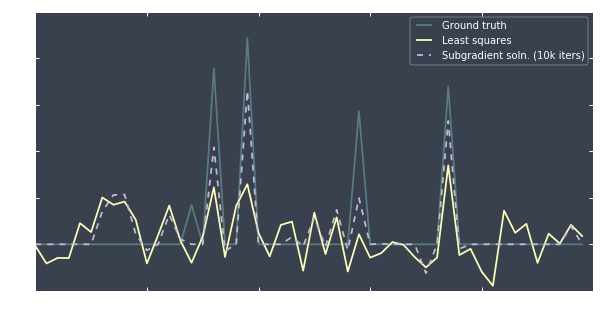

In [8]:
plt.figure(figsize=(10,5))
plt.plot(x, '-', alpha=0.4)
plt.plot(x_lsq, '-')
plt.plot(opt_subg.theta, '--')
plt.legend(['Ground truth', 'Least squares', 'Subgradient soln. (10k iters)'])

## ADMM / Proximal methods

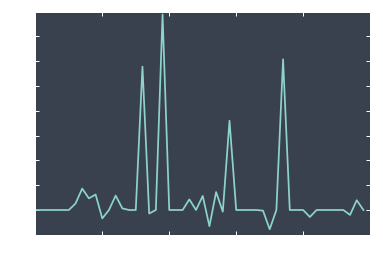

In [15]:
operators = []
opt_admm = descent.Consensus(x_lsq, tau=(1., 1., 1.))
opt_admm.add('linsys', A, y)
opt_admm.add('sparse', 0.5)
opt_admm.run(1000)
plt.plot(opt_admm.theta)

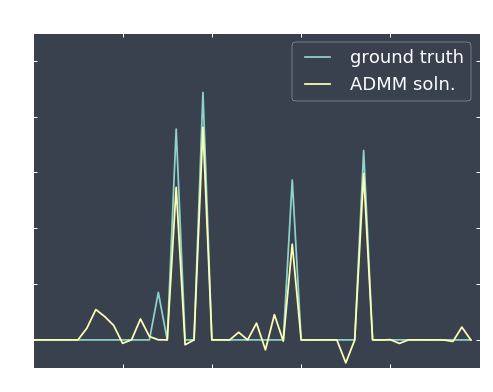

In [24]:
@interact(penalty=(10., 100., 10), maxiter=(50, 500, 50))
def solve_sparsereg(penalty=1., maxiter=100):
    opt_admm = descent.Consensus(x_lsq, tau=(2., 1., 1.))
    opt_admm.add('linsys', A, y)
    opt_admm.add('sparse', penalty)
    opt_admm.run(maxiter)
    
    plt.figure(figsize=(8,6))
    plt.title('$\lambda = {}$, run for {} iterations'.format(penalty, maxiter), fontsize=24)
    plt.plot(x)
    plt.plot(opt_admm.theta, '-')
    plt.ylim(-10, 110)
    plt.legend(['ground truth', 'ADMM soln.'], fontsize=18, loc='upper right')

In [32]:
def compare_algs(penalty, maxiter):
    
    
    # ADMM
    opt_admm = descent.Consensus(x_lsq, tau=(2.,1.,1.))
    opt_admm.add('linsys', A, y)
    opt_admm.add('sparse', penalty)
    opt_admm.objective = lambda theta: f_df_sparse(theta, penalty=penalty)[0]
    opt_admm.run(maxiter=maxiter)
    
    # Subgradient descent
    f_df = partial(f_df_sparse, penalty=penalty)
    opt_subg = descent.GradientDescent(x_lsq, f_df, 'sgd', {'lr': 1e-2}, proxop=descent.proxops.sparse(penalty), rho=1.0)
    opt_subg.run(maxiter=maxiter)
    
    return opt_admm, opt_subg

(-5, 400)

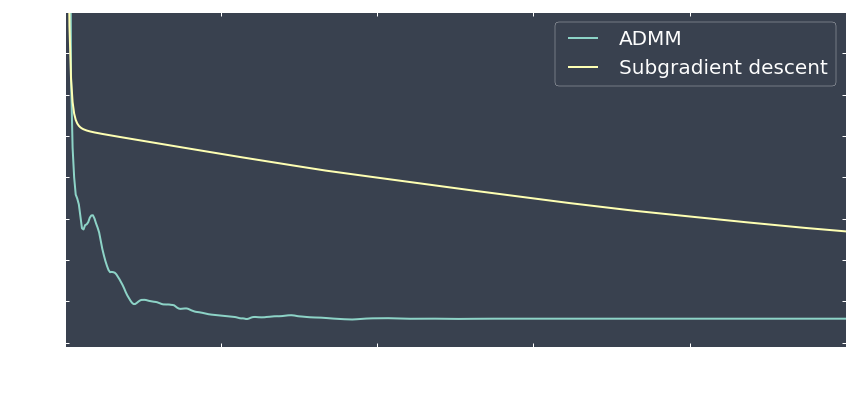

In [33]:
# run the comparison
admm, subg = compare_algs(2., 500)

# plot the results
fstar = f_df_sparse(x, penalty=2.)[0]
plt.figure(figsize=(14,6))
plt.plot(admm.store.get('objective')-fstar, lw=2)
plt.plot(subg.store.get('objective')-fstar, lw=2)
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Objective ($f(x^k) - f(x^*)$', fontsize=20)
plt.legend(['ADMM', 'Subgradient descent'], loc=0, frameon=True, fancybox=True, fontsize=20)
plt.ylim(-5,400)